In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tqdm.autonotebook import tqdm, trange
import itertools
from matplotlib import pyplot as plt

import pandas as pd
import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import random

import importlib
import evaluation
import load_data
import Padgan_variants
# import GANs

importlib.reload(evaluation)
importlib.reload(load_data)
# importlib.reload(GANs)
importlib.reload(Padgan_variants)

<module 'Padgan_variants' from 'C:\\Users\\Lyle\\Documents\\Files\\DeCoDE\\Bike Project\\DeCoDE-Bike-Project-Git\\Structural Analysis\\Padgan_variants.py'>

In [3]:
def plot(ax, rangearr, xx, yy, Z, x, y, title, boundary=0.0, color="blue", plottype = 1):
    if plottype==1:
        ax.contourf(xx, yy, Z, cmap="RdBu", alpha=0.1)
        ax.scatter(x,y, s=3, c=color)
    elif plottype==2:
        ax.imshow(Z.T, cmap="viridis", alpha=0.5, origin='lower', extent = [-2,2,-2,2])
        ax.scatter(x,y, s=3, c=color, alpha = 0.1)
    else:
        ax.scatter(x,y, s=3, c=color)
    ax.set_title(title)
    xlen = rangearr[0,1]-rangearr[0,0]
    ylen = rangearr[1,1]-rangearr[1,0]
    ax.set_xlim(rangearr[0,0]-xlen*boundary, rangearr[0,1]+xlen*boundary)
    ax.set_ylim(rangearr[1,0]-ylen*boundary, rangearr[1,1]+ylen*boundary)
    ax.axis('off')

C:\Users\Lyle\AppData\Local\Temp/ipykernel_28388/1472824196.py:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  methods=pd.Series()
C:\Users\Lyle\AppData\Local\Temp/ipykernel_28388/1472824196.py:82: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  metrics=pd.Series()


No classifier provided! Fitting DNN Classifier using provided Parameters...
Epoch 1/2000
160/160 [==============================] - 0s 1ms/step - loss: 0.6911 - accuracy: 0.4806 - val_loss: 0.6891 - val_accuracy: 0.4187
Epoch 2/2000
160/160 [==============================] - 0s 851us/step - loss: 0.6889 - accuracy: 0.4821 - val_loss: 0.6864 - val_accuracy: 0.4415
Epoch 3/2000
160/160 [==============================] - 0s 848us/step - loss: 0.6863 - accuracy: 0.5052 - val_loss: 0.6835 - val_accuracy: 0.5405
Epoch 4/2000
160/160 [==============================] - 0s 832us/step - loss: 0.6843 - accuracy: 0.5487 - val_loss: 0.6807 - val_accuracy: 0.5585
Epoch 5/2000
160/160 [==============================] - 0s 838us/step - loss: 0.6819 - accuracy: 0.5674 - val_loss: 0.6783 - val_accuracy: 0.5770
Epoch 6/2000
160/160 [==============================] - 0s 838us/step - loss: 0.6790 - accuracy: 0.5857 - val_loss: 0.6747 - val_accuracy: 0.6168
Epoch 7/2000
160/160 [============================

KeyboardInterrupt: 

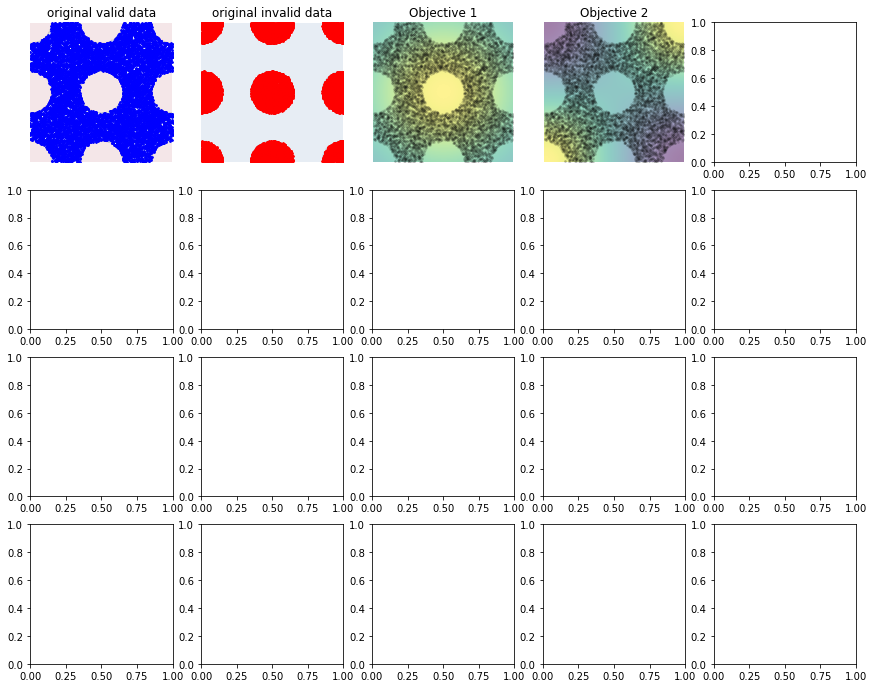

In [9]:
# importlib.reload(evaluation)
# importlib.reload(load_data)
# importlib.reload(GANs)
# importlib.reload(Padgan_variants)

numgen = 500 #Number of samples to generate
numinst = 10 #Number of instantiations to test
scaling = True #Scale or not
scorebars = True #Print progress bars for scoring functions

#Select problems to test
functions=[]

sampling_func_1 = load_data.sample_uniform_wrapper(10000, 10000) #Uniform Sampling with Number of positive samples & Negative Samples
validity_func_1 = load_data.circles_val_wrapper(0.3)
# objs_1 = [load_data.uniform_obj_wrapper(), load_data.uniform_obj_wrapper()]
objs_1 = [load_data.circle_obj_wrapper(0), load_data.rectangles_obj_wrapper(2, 2)]
rangearr_1 = np.array([[-1,1], [-1,1]])
functions.append([sampling_func_1, validity_func_1, objs_1, rangearr_1])

sampling_func_2 = load_data.sample_uniform_wrapper(10000, 10000) #Uniform Sampling with Number of positive samples & Negative Samples
validity_func_2 = load_data.concentric_circles_val_wrapper(2)
objs_2 = [load_data.circle_obj_wrapper(0), load_data.rectangles_obj_wrapper(2, 2)]
rangearr_2 = np.array([[-1,1], [-1,1]])
functions.append([sampling_func_2, validity_func_2, objs_2, rangearr_2])

sampling_func_3 = load_data.sample_uniform_wrapper(10000, 10000) #Uniform Sampling with Number of positive samples & Negative Samples
validity_func_3 = load_data.rectangles_val_wrapper(1, 1)
objs_3 = [load_data.circle_obj_wrapper(0), load_data.rectangles_obj_wrapper(2, 2)]
rangearr_3 = np.array([[-2,2], [-2,2]])
functions.append([sampling_func_3, validity_func_3, objs_3, rangearr_3])

sampling_func_4 = load_data.sample_uniform_wrapper(10000, 10000) #Uniform Sampling with Number of positive samples & Negative Samples
validity_func_4 = load_data.radial_circles_val_wrapper(1.3, 0.45, 6)
objs_4 = [load_data.circle_obj_wrapper(0), load_data.rectangles_obj_wrapper(2, 2)]
rangearr_4 = np.array([[-2,2], [-2,2]])
functions.append([sampling_func_4, validity_func_4, objs_4, rangearr_4])

#Find the highest number of objectives in any problem
max_obj = 0
for i in range(len(functions)):
    if len(functions[i][2])>max_obj:
        max_obj = len(functions[i][2])

#Select methods to test
methods=pd.Series()

# Train params: [def_batch_size, def_disc_lr, def_disc_aux_lr, def_gen_lr, def_noise_dim, def_disc_dim, def_steps]
def_train_params = [32, 1e-3, 1e-4, 1e-3, 4, 1, 10000]
gram_train_params = [100, 1e-3, 1e-4, 1e-3, 20, 10, 10000]

# Config Params: = [cont_delay, validity_weight, pretrain_aux, normal_train_aux, def_gram, diversity]
GAN_config_params = [None, 0, False, False, 0]
ContGAN_config_params = [0, 0.4, False, False, 0]
gram_config = [None, 0, False, True, 0]
ContGAN_VW1 = [0, 0.2, False, False, 0.03]
ContGAN_VW2 = [0, 0.6, False, False, 0.1]
# ContGAN_Div1 = [0, 0.4, False, False, 0.03]
# ContGAN_Div2 = [0, 0.4, False, False, 0.1]

# methods["GAN"] = GANs.contrastive_wrapper(def_train_params, GAN_config_params)
# methods["GRAM-Net"] = GANs.contrastive_wrapper(gram_train_params, gram_config)
# methods["ContGAN_VW=0.2"] = GANs.contrastive_wrapper(def_train_params, ContGAN_VW1)
# methods["ContGAN_VW=0.4"] = GANs.contrastive_wrapper(def_train_params, ContGAN_config_params)
# methods["ContGAN_VW=0.6"] = GANs.contrastive_wrapper(def_train_params, ContGAN_VW2)
# methods["ContGAN+0.1_Div"] = GANs.contrastive_wrapper(def_train_params, ContGAN_VW2)
# methods["ContGAN+0.03_Div"] = GANs.contrastive_wrapper(def_train_params, ContGAN_Div1)
# methods["ContGAN+0.1_Div"] = GANs.contrastive_wrapper(def_train_params, ContGAN_Div2)
# methods["GRAM+Cont"] = GANs.contrastive_wrapper(gram_train_params, ContGAN_config_params)

# Regressor/Classifier params: [dropout, layers, layersize, batchnorm, activation, patience, lr, batchsize, epochs]
reg_clf_params = [0.1, 2, 100, True, "Leaky ReLU", 30, 1e-4, 100, 2000]
config_params = [True, True, True, "auto", "auto"]
train_params = [5, 0.5, 4, 5000]
DTAI_params= ["auto", "auto", "auto"]
methods["PaDGAN+DTAI+CLF"] = Padgan_variants.padgan_wrapper(config_params, train_params, DTAI_params, reg_clf_params, reg_clf_params)

#Select Metrics to evaluate
target = np.array([0.5, 0.5])
a_ = np.array([1, 1])
p_ = np.array([1, 1])
metrics=pd.Series()
metrics["Gen_gen_distance"] = evaluation.gen_gen_distance_wrapper("x", "min")
metrics["Gen_data_distance"] = evaluation.gen_data_distance_wrapper("x", "min")
metrics["Data_gen_distance"] = evaluation.data_gen_distance_wrapper("x", "min")
metrics["Gen_neg_distance"] = evaluation.gen_neg_distance_wrapper("min")
# metrics["Minimum Target Ratio"] = evaluation.minimum_target_ratio_wrapper(target)
# metrics["DTAI"] = evaluation.DTAI_wrapper(target, a_, p_)
# metrics["Hypervolume"] = evaluation.Hypervolume_wrapper()
# metrics["Weighted Target Success Rate"] = evaluation.weighted_target_success_rate_wrapper(target, p_)
metrics["Recall"] = evaluation.recall_wrapper("x")
metrics["Precison"] = evaluation.precision_wrapper("x")
metrics["F1"] = evaluation.F_wrapper("x", 1)
metrics["F10"] = evaluation.F_wrapper("x", 10)
metrics["F0.1"] = evaluation.F_wrapper("x", 0.1)
metrics["AUC-PR"] = evaluation.AUC_wrapper("x")
metrics["MMD"] = evaluation.MMD_wrapper()
metrics["Target Threshold Distance"] = evaluation.target_threshold_distance_wrapper(target, a_)

metrics["Validity"] = "valflag"

scores=np.zeros((len(functions), len(methods), len(metrics), numinst))

#Set up plots
validity_status = 1
obj_status = 1
plots_in_row = 1 + validity_status +(len(methods)+max_obj*obj_status)
#Loop over training instances
for inst in range(numinst):
    fig, ax = plt.subplots(len(functions), plots_in_row, figsize=(3*plots_in_row-0.2, 3*len(functions)-0.2))
    
    #Loop over problems to test
    for func in range(len(functions)):
        samplingfunction, validityfunction, objectives, rangearr = functions[func]
        valid, invalid, scaler = load_data.gen_toy_dataset(samplingfunction, validityfunction, objectives, rangearr, scaling)
        y_valid = load_data.eval_obj(valid, objectives)
        #Generate Colored Background
        
        
        if scaling: 
            v_s = scaler.inverse_transform(valid)
            try:
                i_s = scaler.inverse_transform(invalid)
            except:
                i_s = np.array([[None,None]])
        else:
            v_s = valid
            i_s = invalid
        xx, yy, Z = load_data.gen_background_plot(validityfunction, rangearr)
        plot(fig.axes[plots_in_row*func], rangearr, xx, yy, Z, v_s[:,0], v_s[:,1], "original valid data", plottype=validity_status)
        if validity_status==1:
            plot(fig.axes[plots_in_row*func+1], rangearr, xx, yy, Z, i_s[:,0], i_s[:,1], "original invalid data", color="red")
        if obj_status==1:
            for i in range(len(objectives)):
                xx_o, yy_o, Z_o = load_data.gen_background_plot(objectives[i], rangearr)
                obj_idx = plots_in_row*func+1+validity_status+i
                plot(fig.axes[obj_idx], rangearr, xx_o, yy_o, Z_o, v_s[:,0], v_s[:,1], "Objective " +str(i+1), color="black", plottype = 2)

        #Loop over methods to test
        for i in range(len(methods)): 
            method = methods.values[i]
            model = method(valid, invalid, y_valid)
            x_fake = model.generate(numgen)
            y_fake = load_data.eval_obj(x_fake, objectives)
            if scaling==True:
                x_fake = scaler.inverse_transform(x_fake)


            for j in range(len(metrics)):
                if metrics.values[j]=="valflag":
                    allscores, meanscore = evaluation.evaluate_validity(x_fake, validityfunction)
                else:
                    allscores, meanscore = metrics.values[j](x_fake, y_fake, valid, y_valid, invalid, scorebars)
                scores[func, i, j, inst] = meanscore
            res_idx=plots_in_row*func+1+validity_status+len(objectives)*obj_status+i
            plot(fig.axes[res_idx], rangearr, xx, yy, Z, x_fake[:,0], x_fake[:,1], methods.index[i], plottype=validity_status)
    plt.show()
    fig.savefig("Contrastive_Results_" + str(inst) + ".png", dpi=400)
    
for i in range(np.shape(scores)[0]):
    meanscores = np.mean(scores[i], axis=(2))
    scoredf = pd.DataFrame(meanscores, index=methods.index, columns = metrics.index).transpose()
    scoredf.columns.name="Problem " + str(i+1) + " Scores:"
    print(scoredf)
#     scoredf.to_csv("Contrastive_scores.csv", index_label=scoredf.columns.name)

#average scores

meanscores = np.mean(scores, axis=(0,3))
scoredf = pd.DataFrame(meanscores, index=methods.index, columns = metrics.index).transpose()
scoredf.columns.name="Average scores:"
print(scoredf)
scoredf.to_csv("Contrastive_scores.csv", index_label=scoredf.columns.name)